In [2]:
%pip install evaluate
%pip install torch
%pip install transformers

Keyring is skipped due to an exception: 'keyring.backends'
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
from transformers import AutoModel, BertTokenizerFast, GPT2LMHeadModel, AutoTokenizer

subreddit = "subreddit-wallstreetbets"
experiment_name = "sorted_by_upvotes"
version=1

model_path = f"./model_output_{experiment_name}_{subreddit}_{version}/"

model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [4]:
from datasets import load_from_disk

datasets = load_from_disk(f"./train_test_{experiment_name}_{subreddit}")

In [5]:
import evaluate 

bleu = evaluate.load("bleu")


In [101]:
lengths = [len(x["utterance"]) for x in datasets["test"]]
min_length = 128
def only_above_threshold(text):
    return len(text['utterance']) >= min_length
def get_utterance(x):
    return x['utterance']

test_dataset = list(map(get_utterance, filter(only_above_threshold, datasets["test"])))

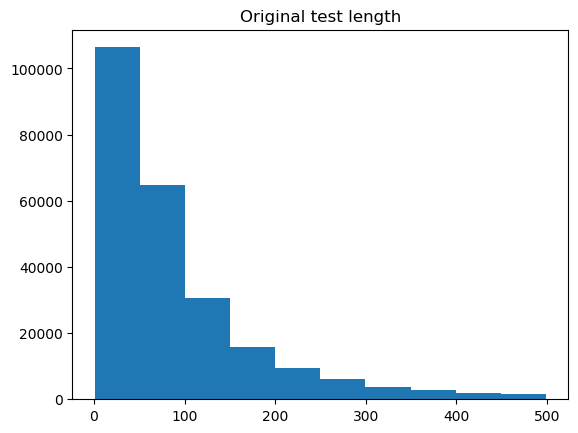

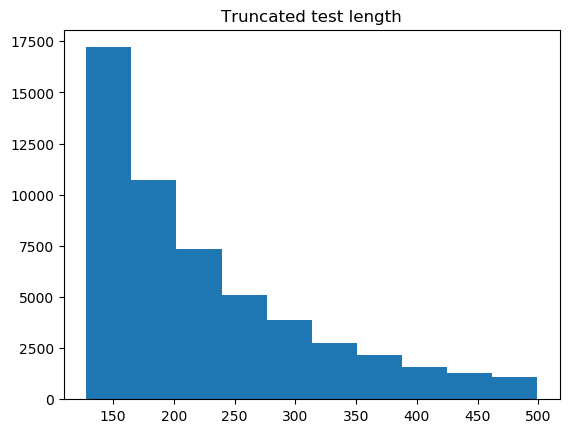

In [102]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.title("Original test length")
plt.show()

plt.hist([len(x) for x in test_dataset])
plt.title("Truncated test length")
plt.show()

In [112]:
# Evaluate it
import random
import torch
from transformers import pipeline
from tqdm import tqdm

test_set = test_dataset[:128]
references = test_set
batch_size = 8 # 64

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)

predictions = []
prompts_for_predictions = []

for i in tqdm(range(0, len(test_set), batch_size)):
    batch = test_set[i:i + batch_size]
    prompts = []
    max_length = 5
    for text in batch:
        tokens = text.split()
        prompt = " ".join(tokens[: len(tokens)//2])
        max_length = max(max_length, len(tokens)//2)
        prompts.append(prompt)
    # prediction = pipe(prompts, num_return_sequences=1, max_new_tokens=int(max_length * 1.1), clean_up_tokenization_spaces=True, temperature=0.1, do_sample=True, pad_token_id=50256)
    prediction = pipe(prompts, num_return_sequences=1, clean_up_tokenization_spaces=True, temperature=0.1, do_sample=True, pad_token_id=50256)
    prompts_for_predictions += prompts
    predictions += list(map(lambda x : x[0]['generated_text'], prediction))

  0%|          | 0/16 [00:00<?, ?it/s]Input length of input_ids is 84, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 75, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
 19%|█▉        | 3/16 [00:05<00:23,  1.78s/it]Input length of input_ids is 52, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 75, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
 38%|███▊      | 6/16 [00:10<00:18,  1.81s/it]Input length of input_ids is 50, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 70, but `max_length` is set to 50. This can lead to unexpected behavior. You should co

In [113]:
predictions_without_prompt = list(map(lambda x : x[0][len(x[1]):], zip(predictions, prompts_for_predictions)))
reference_text_after_prompt =  list(map(lambda x : x[0][len(x[1]):], zip(references, prompts_for_predictions)))

results = bleu.compute(predictions=predictions_without_prompt, references=reference_text_after_prompt)


In [114]:
results

{'bleu': 0.03991599501010396,
 'precisions': [0.19349005424954793,
  0.05422264875239923,
  0.04369918699186992,
  0.04150943396226415],
 'brevity_penalty': 0.6043410207242385,
 'length_ratio': 0.6650631389055923,
 'translation_length': 2212,
 'reference_length': 3326}

In [115]:
# See some of the predictions vs actual
for prompt, pred, ref in zip(prompts_for_predictions, predictions_without_prompt, reference_text_after_prompt):
    print("=" * 10)
    print("Prompt:\t\t", prompt)
    print("Prediction:\t", pred)
    print("Reference:\t", ref)    

Prompt:		 Sold JNUG @11.70 this morning, profiting .80/share Bought GUSH and regretted that all day. holding it
Prediction:	  for a while. 

I'm not sure what to do with my hands. 

Edit
Reference:	  over the weekend
Picked JNUG back up after market closed at 10.43 to hold over the weekend 
Prompt:		 check the news stream from china looks like they are going to invest their pensions into the market to try to prop it up... http://economictimes.indiatimes.com/markets/stocks/news/china-to-invest-massive-pension-fund-in-volatile-stock-markets/articleshow/48643806.cms NOt saying BABA and others like
Prediction:	  it
Reference:	 ike Amazon and Tesla don't have a long way to fall, but I'd let the vix fall a bit and use strength to get into these puts rather than first thing mon 
Prompt:		 So you mean, that's the speculative value. So go short forl the short term market gains. (irrational markets)
Prediction:	 

Or, you know, short the market gains. 

Or, you know, short the market gains
Refer